In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '../scripts/')

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 196

In [3]:
%load_ext autoreload
%autoreload 1

In [21]:
%aimport shapeslib
%aimport etllib
%aimport constants


In [5]:
shapes_file = '../wip/smoothshape/ddf--datapoints--population_percentage--by--country--year--coverage_type--bracket.csv'
known_shapes = pd.read_csv(shapes_file)

In [6]:
# create a sorted version
shapes = known_shapes.set_index(['country', 'year']).sort_index()

In [7]:
income_file = '../../../ddf--gapminder--fasttrack/ddf--datapoints--mincpcap_cppp--by--country--time.csv'
gini_file =  '../../../ddf--gapminder--fasttrack/ddf--datapoints--gini--by--country--time.csv'

In [10]:
bracket_number_from_income = etllib.bracket_number_from_income

In [11]:
income = pd.read_csv(income_file).set_index(['country', 'time'])
gini = pd.read_csv(gini_file).set_index(['country', 'time'])

income.index.names = ['country', 'year']
gini.index.names = ['country', 'year']

income.columns = ['income']
gini.columns = ['gini']

In [12]:
income_gini = pd.concat([income, gini], axis=1)

In [13]:
income_gini = income_gini.dropna(how='any').sort_index()

In [14]:
shapes_noc = shapes.copy()
shapes_noc = shapes_noc.set_index(['bracket'], append=True)

In [15]:
def applyfunc(ser):
    for c in 'naur':
        if c in ser['coverage_type'].values:
            return ser[ser['coverage_type'] == c]['population_percentage']

In [16]:
shapes_noc2 = shapes_noc.groupby(['country', 'year'], as_index=False).apply(applyfunc)
shapes_noc2 = shapes_noc2.reset_index(level=0, drop=True).sort_index()

In [17]:
shapes_noc3 = shapes_noc2.reset_index()
shapes_noc3 = shapes_noc3.set_index(['country', 'year'])

In [18]:
shapes_noc4 = shapes_noc2.reset_index()
shapes_noc4['country-year'] = list(zip(shapes_noc4['country'].values, shapes_noc4['year'].values))
shapes_noc4 = shapes_noc4.set_index(['country-year', 'bracket'])['population_percentage']

In [36]:
shapes_noc4

country-year  bracket
(ago, 1981)   -94        7.153827e-06
              -93        8.619550e-06
              -92        1.029801e-05
              -91        1.214019e-05
              -90        1.423205e-05
                             ...     
(zwe, 2019)    105       1.402410e-07
               106       1.090947e-07
               107       8.406808e-08
               108       6.417809e-08
               109       4.857008e-08
Name: population_percentage, Length: 1277800, dtype: float64

In [37]:
shapes_noc2

country  year  bracket
ago      1981  -94        7.153827e-06
               -93        8.619550e-06
               -92        1.029801e-05
               -91        1.214019e-05
               -90        1.423205e-05
                              ...     
zwe      2019   105       1.402410e-07
                106       1.090947e-07
                107       8.406808e-08
                108       6.417809e-08
                109       4.857008e-08
Name: population_percentage, Length: 1277800, dtype: float64

In [22]:
all_years = set(range(1800, 2051))
all_weights = dict([(x, constants.get_weights(x)) for x in all_years])

In [23]:
from multiprocessing import Pool
import json
from functools import partial

In [24]:
fp = open('../wip/neighbours_list.json', 'r')
all_neighbours_json = json.load(fp)

In [103]:
def get_average_shape(c, y, shapes, neighbours):
    y = str(y)
    nei = neighbours[c][y]['neighbours']
    nei = [tuple(x) for x in nei]
    return shapes.loc[shapes.index.get_level_values(0).isin(nei)].groupby('bracket').sum() / 50

In [104]:
%%timeit

get_average_shape('ago', 1800, shapes_noc4, all_neighbours_json)

55.8 ms ± 183 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [63]:
def mask_shape(idx, check_list):
    mask = []
    for x in idx:
        val = [x[0], x[1]]  # [country, year]
        if val in check_list:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [84]:
def mask_shape2(idx, check_list):
    # cl = [tuple(x) for x in check_list]
    return idx.isin(check_list)

In [94]:
def mask_shape3(idx, check_list):
    # cl = [tuple(x) for x in check_list]
    return idx.map(lambda x: x in check_list)

In [66]:
nei

[['sle', 1999],
 ['sle', 2000],
 ['sle', 1998],
 ['bdi', 1997],
 ['sle', 2001],
 ['sle', 1997],
 ['sle', 1996],
 ['sle', 1995],
 ['sle', 2002],
 ['sle', 1994],
 ['bdi', 1999],
 ['ner', 2006],
 ['mwi', 2005],
 ['sle', 1993],
 ['mdg', 2006],
 ['rwa', 1994],
 ['mdg', 2007],
 ['mdg', 1996],
 ['sle', 2003],
 ['sle', 1992],
 ['mli', 2000],
 ['ben', 1989],
 ['btn', 1981],
 ['btn', 1982],
 ['btn', 1983],
 ['bdi', 2000],
 ['btn', 1984],
 ['uga', 1993],
 ['btn', 1985],
 ['ben', 1990],
 ['uga', 1997],
 ['uga', 1994],
 ['ben', 1988],
 ['gin', 2005],
 ['ben', 1991],
 ['nga', 1987],
 ['mdg', 2005],
 ['btn', 1986],
 ['sle', 1991],
 ['gnb', 2005],
 ['ner', 1994],
 ['ben', 1987],
 ['ben', 1992],
 ['mdg', 2008],
 ['nga', 2004],
 ['mwi', 2004],
 ['tza', 2007],
 ['eth', 1996],
 ['gin', 2006],
 ['nga', 2005]]

In [75]:
shapes_noc2.loc[mask_shape2(shapes_noc2.index, nei)]

country  year  bracket
bdi      1997  -72        2.709944e-05
               -71        3.288276e-05
               -70        3.928195e-05
               -69        4.617997e-05
               -68        5.382412e-05
                              ...     
uga      1997   115       4.257126e-10
                116       2.835563e-10
                117       1.846997e-10
                118       1.175363e-10
                119       7.289146e-11
Name: population_percentage, Length: 10000, dtype: float64

In [107]:
def get_average_shape_2(c, y, shapes, neighbours):
    y = str(y)
    nei = neighbours[c][y]['neighbours']
    nei = set([tuple(x) for x in nei])
    return shapes.loc[shapes.index.droplevel(-1).isin(nei)].groupby('bracket').sum() / 50

In [108]:
%%timeit

get_average_shape_2('ago', 1800, shapes_noc2, all_neighbours_json)

98.4 ms ± 299 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [99]:
def get_average_shape_3(c, y, shapes, neighbours):
    y = str(y)
    nei = neighbours[c][y]['neighbours']
    nei = set([tuple(x) for x in nei])
    return shapes.loc[mask_shape2(shapes.index.droplevel(-1), nei)].groupby('bracket').sum() / 50

In [100]:
%%timeit

get_average_shape_3('ago', 1800, shapes_noc2, all_neighbours_json)

99 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [116]:
country_year = list(zip(shapes_noc2.index.get_level_values(0), shapes_noc2.index.get_level_values(1)))
country_year = pd.Series(country_year, index=shapes_noc2.index)

421 ms ± 6.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [115]:
%%timeit 
shapes_noc2.loc[country_year.isin(nei)]

38.6 ms ± 792 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [131]:
def get_average_shape2(c, y, shapes, all_country_year, neighbours):
    y = str(y)
    nei = neighbours[c][y]['neighbours']
    nei = [tuple(x) for x in nei]
    mask = all_country_year.isin(nei)
    return shapes.loc[mask].groupby('bracket').sum() / 50

In [132]:
%%timeit

get_average_shape2('ago', 1800, shapes_noc2, country_year, all_neighbours_json)

33.8 ms ± 776 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
def get_nearest_known_shape(country, year, known_shapes):
    try:
        df = known_shapes.loc[country]
    except KeyError:
        return None
    
    if year > 2017:
        nearest = df.index.get_level_values(0)[-1]
        # print(nearest)
    else:
        nearest = df.index.get_level_values(0)[0]
    return df.loc[nearest]

In [133]:
def get_estimated_mountain(idx, income, known_shapes, all_country_year, neighbours, n=50):
    country, year = idx
    wpov, was = all_weights[year]
    
    first_known_shape = get_nearest_known_shape(country, year, known_shapes)
    if first_known_shape is None:
        return None
    
    if wpov == 1:
        mixed_shape = first_known_shape
    elif wpov == 0:        
        mixed_shape = get_average_shape2(country, year, known_shapes, all_country_year, neighbours)
    else:
        average_shape = get_average_shape2(country, year, known_shapes, all_country_year, neighbours)
        mixed_shape = shapeslib.merge_nshapes_with_weights([first_known_shape, average_shape], (wpov, was))
        
    return shape_to_mountain(mixed_shape, income)

In [28]:
def shape_to_mountain(shape, income):
    bracket = bracket_number_from_income(income)
    shape.index = shape.index + bracket
    res = shape.loc[0:199]
    if len(res) != 200:
        # print(f'not enough points in mixed shape: {idx}')
        new_idx = pd.Index(range(200))
        res = shape.reindex(new_idx, fill_value=0)
        
    return res

In [29]:
get_nearest_known_shape('ind', 2020, shapes_noc2)

bracket
-91     6.201989e-10
-90     8.123198e-10
-89     1.054200e-09
-88     1.356230e-09
-87     1.723870e-09
            ...     
 104    1.861361e-07
 105    1.587817e-07
 106    1.343057e-07
 107    1.124367e-07
 108    9.314307e-08
Name: population_percentage, Length: 200, dtype: float64

In [34]:
unknown_list = list()

all_countries = income_gini.index.get_level_values(0).unique()
known_countries = shapes.index.get_level_values(0).unique()

for country in all_countries:
    if country not in known_countries:
        unknown_list.append(country)
        print(f'{country} not available in povcal')

afg not available in povcal
and not available in povcal
atg not available in povcal
bhr not available in povcal
bhs not available in povcal
brb not available in povcal
brn not available in povcal
cub not available in povcal
dma not available in povcal
eri not available in povcal
gnq not available in povcal
grd not available in povcal
hkg not available in povcal
khm not available in povcal
kna not available in povcal
kwt not available in povcal
lby not available in povcal
mco not available in povcal
mhl not available in povcal
nzl not available in povcal
omn not available in povcal
plw not available in povcal
prk not available in povcal
qat not available in povcal
sau not available in povcal
sgp not available in povcal
smr not available in povcal
vct not available in povcal


In [123]:
known_list = shapes.index.values.tolist()

In [134]:
def process(i, skip_list, shape_known_list):
    country, year = i
    if country in unknown_list: 
        # only use Average Shapes
        income, _ = shapeslib.get_income_gini(i, income_gini)
        average_shape = get_average_shape2(country, year, shapes_noc2, all_country_year, all_neighbours_json)
        res = shape_to_mountain(average_shape, income)
        return i, res
    if i not in shape_known_list:
        income, _ = shapeslib.get_income_gini(i, income_gini)
        res = get_estimated_mountain(i, income, shapes_noc2, all_country_year, all_neighbours_json)
        # res = shapeslib.get_estimated_mountain(i, shapes, income_gini, resample=False) 
        return i, res

In [135]:
run = partial(process, skip_list=unknown_list, shape_known_list=known_list)

In [138]:
all_country_year = country_year

In [139]:
!date

Fri Oct 15 03:03:21 PM CST 2021


In [140]:
with Pool(6) as p:
    res = p.map(run, income_gini.index.values)

In [141]:
!date

Fri Oct 15 03:28:31 PM CST 2021


In [142]:
res = [x for x in res if x is not None]

In [143]:
len(res)

42556

In [144]:
res2 = []
for k, v in res:
    df = v.copy()
    country, year = k
    # print(country, year)
    df.index.name = 'bracket'
    df.name = 'income_mountain'
    df = df.reset_index()
    df['country'] = country
    df['year'] = year
    df = df.set_index(['country', 'year', 'bracket'])
    res2.append(df)

In [145]:
res3 = pd.concat(res2)

In [146]:
res3

income_mountain
country year bracket                 
afg     1800 0           2.386395e-06
             1           2.685107e-06
             2           3.038148e-06
             3           3.438875e-06
             4           3.890295e-06
...                               ...
zwe     2050 195         4.703014e-07
             196         3.880885e-07
             197         3.185998e-07
             198         2.601386e-07
             199         2.112494e-07

[8511200 rows x 1 columns]

In [48]:
res4 = []
for c in shapes.index.get_level_values('country').unique():
    df = shapes.loc[[c]]
    for ct in 'naur':
        if ct in df['coverage_type'].values:
            df_ = df[df['coverage_type'] == ct].copy()
            df_ = df_.drop(columns='coverage_type')
            res4.append(df_)
            break

In [49]:
res5 = pd.concat(res4)

In [50]:
res6 = []
gs = res5.groupby(['country', 'year'])
for g, df in gs:
    c, y = g
    try:
        i, _ = shapeslib.get_income_gini(g, income_gini)
    except KeyError:
        # print(g)
        continue
    bracket = bracket_number_from_income(i)
    shape = df.copy()
    shape = shape.set_index('bracket')
    shape.index = shape.index + bracket
    result = shape.loc[0:199]
    if len(result) != 200:
        new_idx = pd.Index(range(200))
        result = result.reindex(new_idx, fill_value=0)        
    new_idx2 = pd.MultiIndex.from_product([[c], [y], range(200)], names=['country', 'year', 'bracket'])
    result.index = new_idx2
    res6.append(result)

In [51]:
res7 = pd.concat(res6)

In [52]:
res7

population_percentage
country year bracket                       
ago     1981 0                 7.153827e-06
             1                 8.619550e-06
             2                 1.029801e-05
             3                 1.214019e-05
             4                 1.423205e-05
...                                     ...
zwe     2019 195               1.402410e-07
             196               1.090947e-07
             197               8.406808e-08
             198               6.417809e-08
             199               4.857008e-08

[1277800 rows x 1 columns]

In [71]:
# def shape_to_mountain(shape, country, income_gini):
#     c, y = idx
#     try:
#         i, _ = shapeslib.get_income_gini(idx, income_gini)
#     except KeyError:
#         print(idx)
#         return None
#     bracket = bracket_number_from_income(i)
#     shape = shape_.copy()
#     shape.index = shape.index + bracket
#     res = shape.loc[0:199]
#     print(shape)
#     if len(res) != 200:
#         new_idx = pd.Index(range(200))
#         res = res.reindex(new_idx, fill_value=0)
        
#     new_idx2 = pd.MultiIndex.from_product([[c], [y], range(200)], names=['country', 'year', 'bracket'])
#     res.index = new_idx2
#     return res

In [53]:
res7.columns = ['income_mountain']

In [54]:
res8 = pd.concat([res3, res7])

In [55]:
res8.to_csv('../wip/income_mountain_200brackets.csv')

In [11]:
res8 = pd.read_csv('../wip/income_mountain_200brackets.csv').set_index(['country', 'year', 'bracket']).sort_index()

In [57]:
from ddf_utils.str import format_float_digits
formattor = partial(format_float_digits, digits=6)

In [56]:
res8 = res8.sort_index()

In [57]:
res8.loc[('chn', 1800)].values

array([[1.55589511e-04],
       [1.68297855e-04],
       [1.97079569e-04],
       [2.13309833e-04],
       [2.30251901e-04],
       [2.48013204e-04],
       [2.65649569e-04],
       [2.85125438e-04],
       [3.05961534e-04],
       [3.27912791e-04],
       [3.50546667e-04],
       [3.74234662e-04],
       [3.99400241e-04],
       [4.26781634e-04],
       [4.55883659e-04],
       [4.87112029e-04],
       [5.21361665e-04],
       [5.57296241e-04],
       [5.95782904e-04],
       [6.39732138e-04],
       [6.87023028e-04],
       [7.40519890e-04],
       [7.99372501e-04],
       [8.64894637e-04],
       [9.37255429e-04],
       [1.01571619e-03],
       [1.10694723e-03],
       [1.20594734e-03],
       [1.31807656e-03],
       [1.44993056e-03],
       [1.59938244e-03],
       [1.77061278e-03],
       [1.96277619e-03],
       [2.17543227e-03],
       [2.42424107e-03],
       [2.71033925e-03],
       [3.04254738e-03],
       [3.42839453e-03],
       [3.86831977e-03],
       [4.36224966e-03],


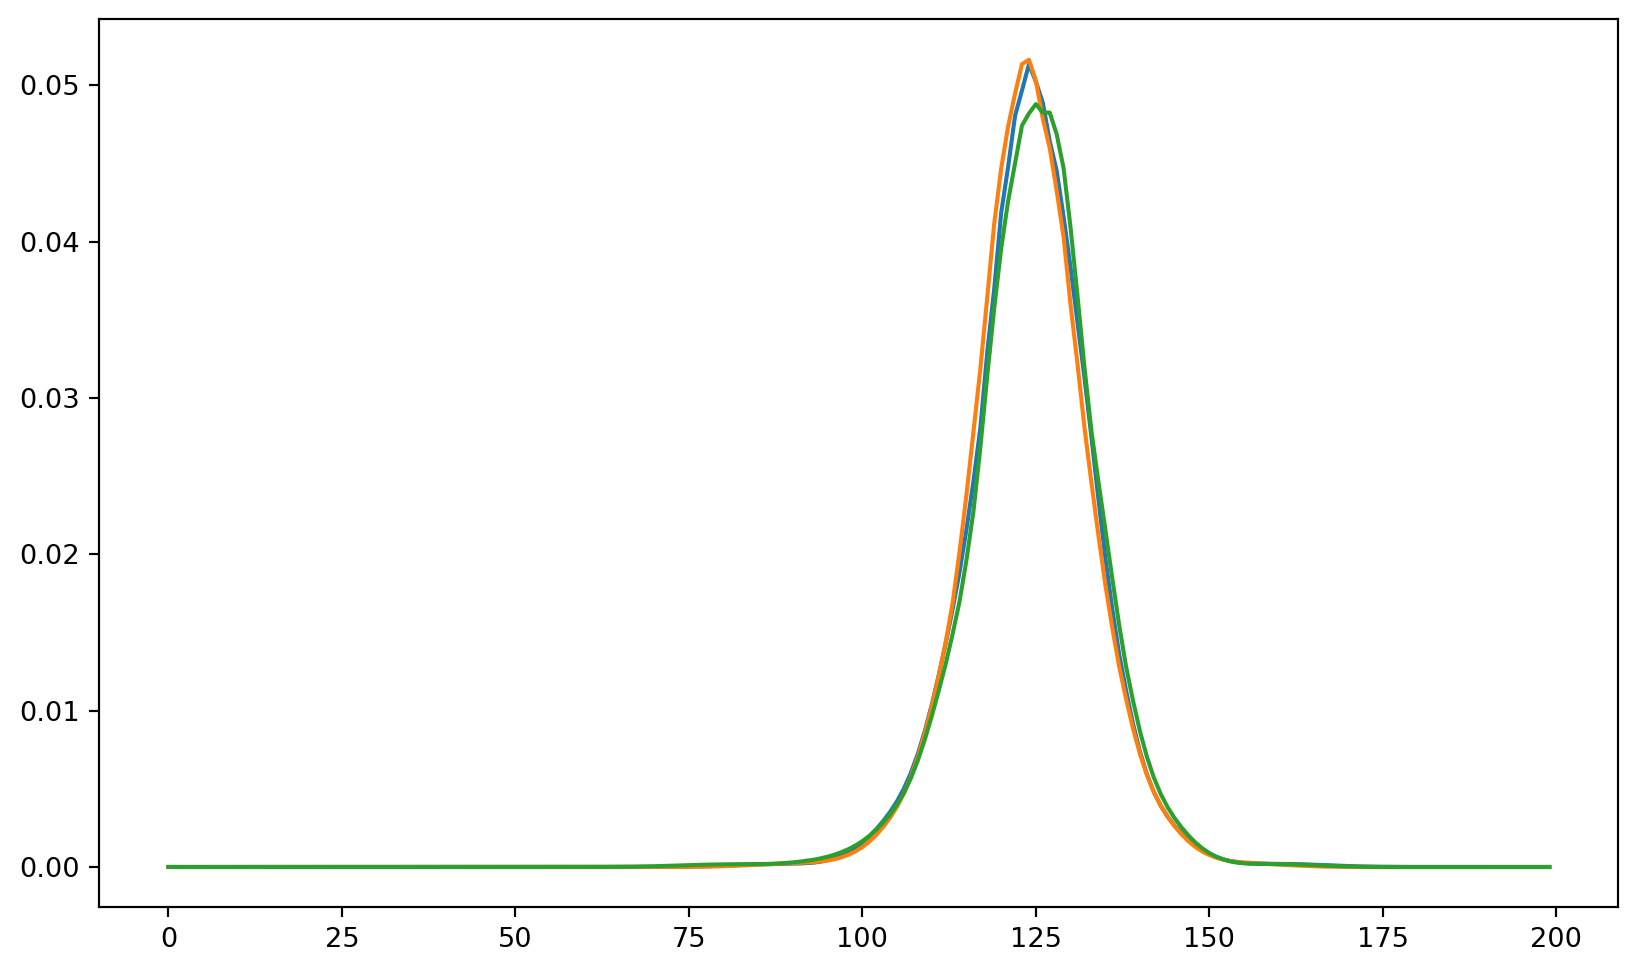

In [58]:
plt.plot(res8.loc[('deu', 2015)])
plt.plot(res8.loc[('deu', 2012)])
plt.plot(res8.loc[('deu', 2017)])

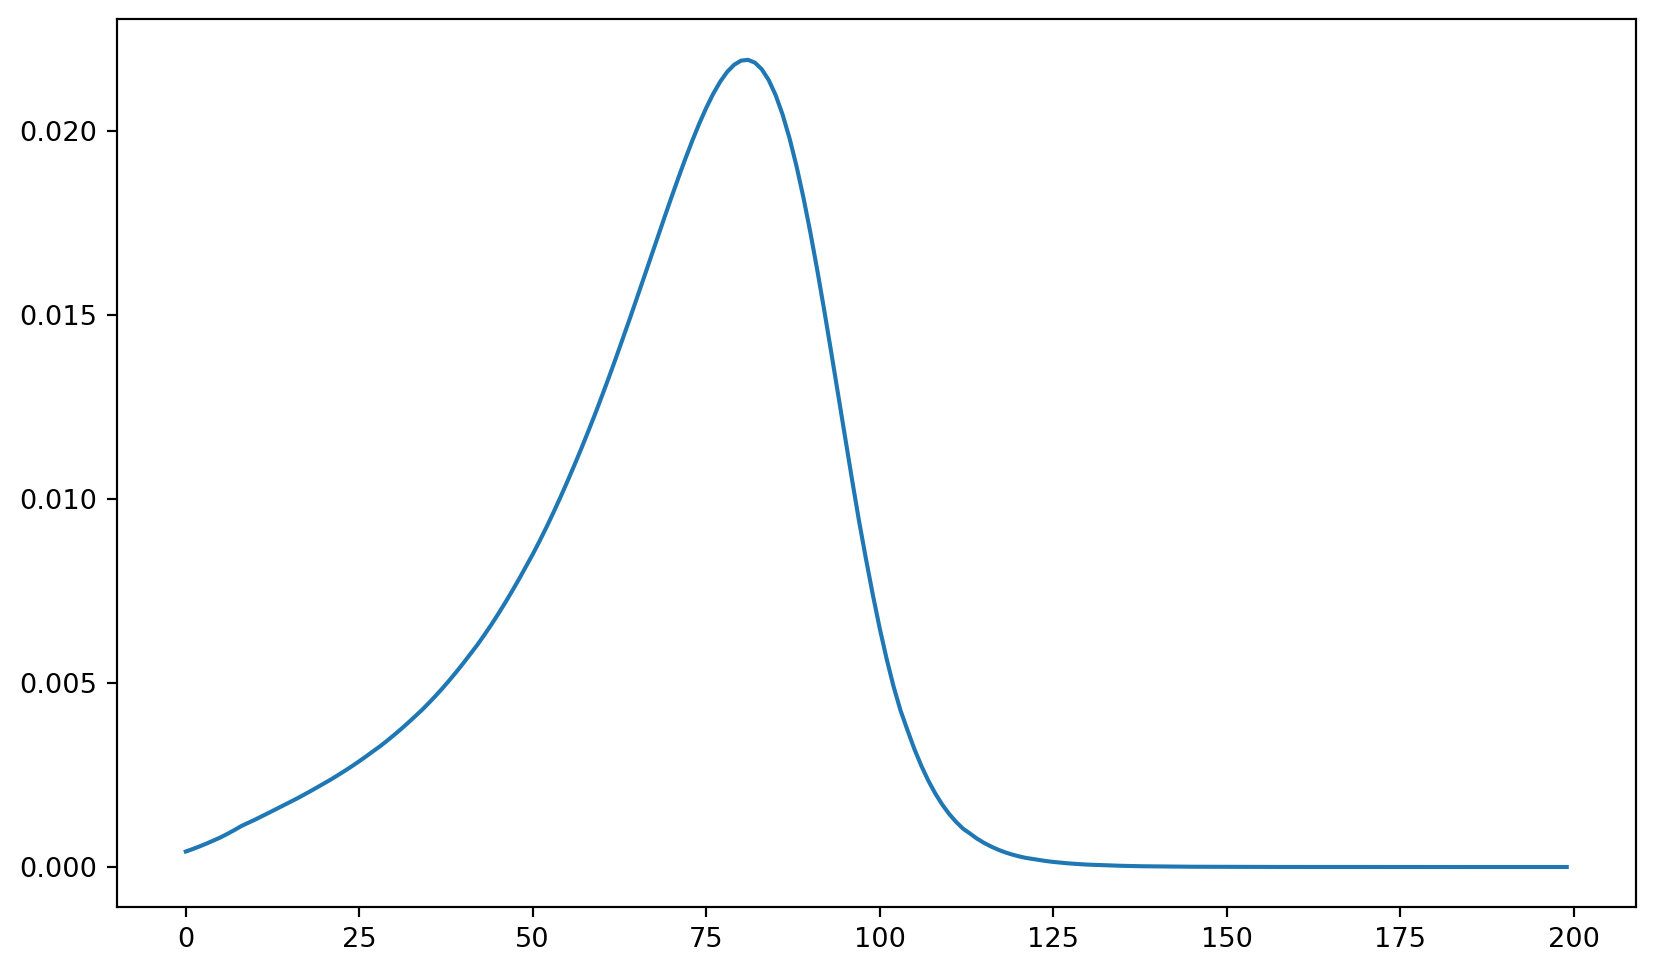

In [59]:
plt.plot(res8.loc[('sle', 1984)])

In [60]:
df = res8.loc[('deu', 1981), 'income_mountain']

In [61]:
pd.Series([x.sum() for x in np.split(df, 50)]).sum()

0.9999999999999962

In [62]:
def resample(ser):
    res = pd.Series([x.sum() for x in np.split(ser.values, 50)])
    res.index.name = 'bracket'
    return res

In [63]:
res9 = res8.groupby(['country', 'year']).apply(resample)

In [64]:
gs = res8.groupby(['country', 'year'])
df = gs.get_group(('deu', 1981))

In [65]:
resample(df)

bracket
0     1.482197e-323
1     3.952525e-323
2     4.446591e-323
3     3.952525e-323
4     2.470328e-323
5     3.458460e-323
6     1.976263e-323
7     1.482197e-323
8     3.458460e-323
9     3.952525e-323
10    2.964394e-323
11    9.881313e-324
12    1.976263e-323
13    3.458460e-323
14    3.458460e-323
15    2.964394e-323
16     6.300874e-08
17     6.314873e-06
18     5.651481e-05
19     2.260873e-04
20     5.404155e-04
21     8.483064e-04
22     1.155821e-03
23     2.259932e-03
24     6.047464e-03
25     1.548913e-02
26     3.986128e-02
27     9.566652e-02
28     1.714625e-01
29     1.976465e-01
30     1.807245e-01
31     1.404139e-01
32     8.308374e-02
33     3.865511e-02
34     1.593636e-02
35     6.015596e-03
36     2.164218e-03
37     1.036683e-03
38     4.918085e-04
39     1.713719e-04
40     3.682760e-05
41     2.967379e-06
42    2.964394e-323
43    1.976263e-323
44    2.964394e-323
45    2.964394e-323
46    3.952525e-323
47    3.952525e-323
48    2.470328e-323
49    3.4584

In [66]:
res9 

bracket             0              1             2         3         4   \
country year                                                              
afg     1800  0.000012   1.879334e-05  3.076009e-05  0.000052  0.000091   
        1801  0.000012   1.879334e-05  3.076009e-05  0.000052  0.000091   
        1802  0.000012   1.879334e-05  3.076009e-05  0.000052  0.000091   
        1803  0.000012   1.879334e-05  3.076009e-05  0.000052  0.000091   
        1804  0.000012   1.879334e-05  3.076009e-05  0.000052  0.000091   
...                ...            ...           ...       ...       ...   
zwe     2046  0.000000   1.557289e-08  5.621468e-07  0.000005  0.000010   
        2047  0.000000  9.881313e-324  2.826463e-07  0.000004  0.000009   
        2048  0.000000   5.792612e-09  3.284974e-07  0.000004  0.000009   
        2049  0.000000   6.294289e-09  3.412251e-07  0.000004  0.000010   
        2050  0.000000   1.648784e-07  7.136702e-07  0.000005  0.000011   

bracket             5         6         7         8         9   ...        40  \
country year                                                    ...             
afg     1800  0.000167  0.000321  0.000647  0.001363  0.002983  ...  0.000001   
        1801  0.000167  0.000321  0.000647  0.001363  0.002983  ...  0.000001   
        1802  0.000167  0.000321  0.000647  0.001363  0.002983  ...  0.000001   
        1803  0.000167  0.000321  0.000647  0.001363  0.002983  ...  0.000001   
        1804  0.000167  0.000321  0.000647  0.001363  0.002983  ...  0.000001   
...                ...       ...       ...       ...       ...  ...       ...   
zwe     2046  0.000017  0.000026  0.000041  0.000064  0.000107  ...  0.000146   
        2047  0.000015  0.000025  0.000038  0.000059  0.000096  ...  0.000161   
        2048  0.000016  0.000025  0.000039  0.000061  0.000099  ...  0.000160   
        2049  0.000017  0.000026  0.000040  0.000063  0.000102  ...  0.000159   
        2050  0.000019  0.000029  0.000044  0.000069  0.000111  ...  0.000158   

bracket                 41            42            43            44  \
country year                                                           
afg     1800  8.213336e-07  4.340338e-07  2.188647e-07  1.056966e-07   
        1801  8.213336e-07  4.340338e-07  2.188647e-07  1.056966e-07   
        1802  8.213336e-07  4.340338e-07  2.188647e-07  1.056966e-07   
        1803  8.213336e-07  4.340338e-07  2.188647e-07  1.056966e-07   
        1804  8.213336e-07  4.340338e-07  2.188647e-07  1.056966e-07   
...                    ...           ...           ...           ...   
zwe     2046  9.790029e-05  6.335044e-05  4.014304e-05  2.453922e-05   
        2047  1.088063e-04  7.076688e-05  4.510082e-05  2.783601e-05   
        2048  1.081985e-04  7.038234e-05  4.486389e-05  2.769628e-05   
        2049  1.076603e-04  7.003507e-05  4.464662e-05  2.756596e-05   
        2050  1.070452e-04  6.965369e-05  4.441861e-05  2.743848e-05   

bracket                 45            46            47        48            49  
country year                                                                    
afg     1800  4.810179e-08  1.875028e-08  2.668005e-10  0.000000  0.000000e+00  
        1801  4.810179e-08  1.875028e-08  2.668005e-10  0.000000  0.000000e+00  
        1802  4.810179e-08  1.875028e-08  2.668005e-10  0.000000  0.000000e+00  
        1803  4.810179e-08  1.875028e-08  2.668005e-10  0.000000  0.000000e+00  
        1804  4.810179e-08  1.875028e-08  2.668005e-10  0.000000  0.000000e+00  
...                    ...           ...           ...       ...           ...  
zwe     2046  1.443742e-05  8.092027e-06  4.282865e-06  0.000002  9.594598e-07  
        2047  1.655083e-05  9.404074e-06  5.056929e-06  0.000003  1.183575e-06  
        2048  1.647282e-05  9.363419e-06  5.037504e-06  0.000003  1.180881e-06  
        2049  1.639885e-05  9.324138e-06  5.018287e-06  0.000003  1.177785e-06  
        2050  1.633252e-05  9.293116e-06  5.006047e-06  0.000

In [67]:
res9.sum(axis=1)

country  year
afg      1800    0.999989
         1801    0.999989
         1802    0.999989
         1803    0.999989
         1804    0.999989
                   ...   
zwe      2046    0.999999
         2047    0.999999
         2048    0.999999
         2049    0.999999
         2050    0.999999
Length: 48945, dtype: float64

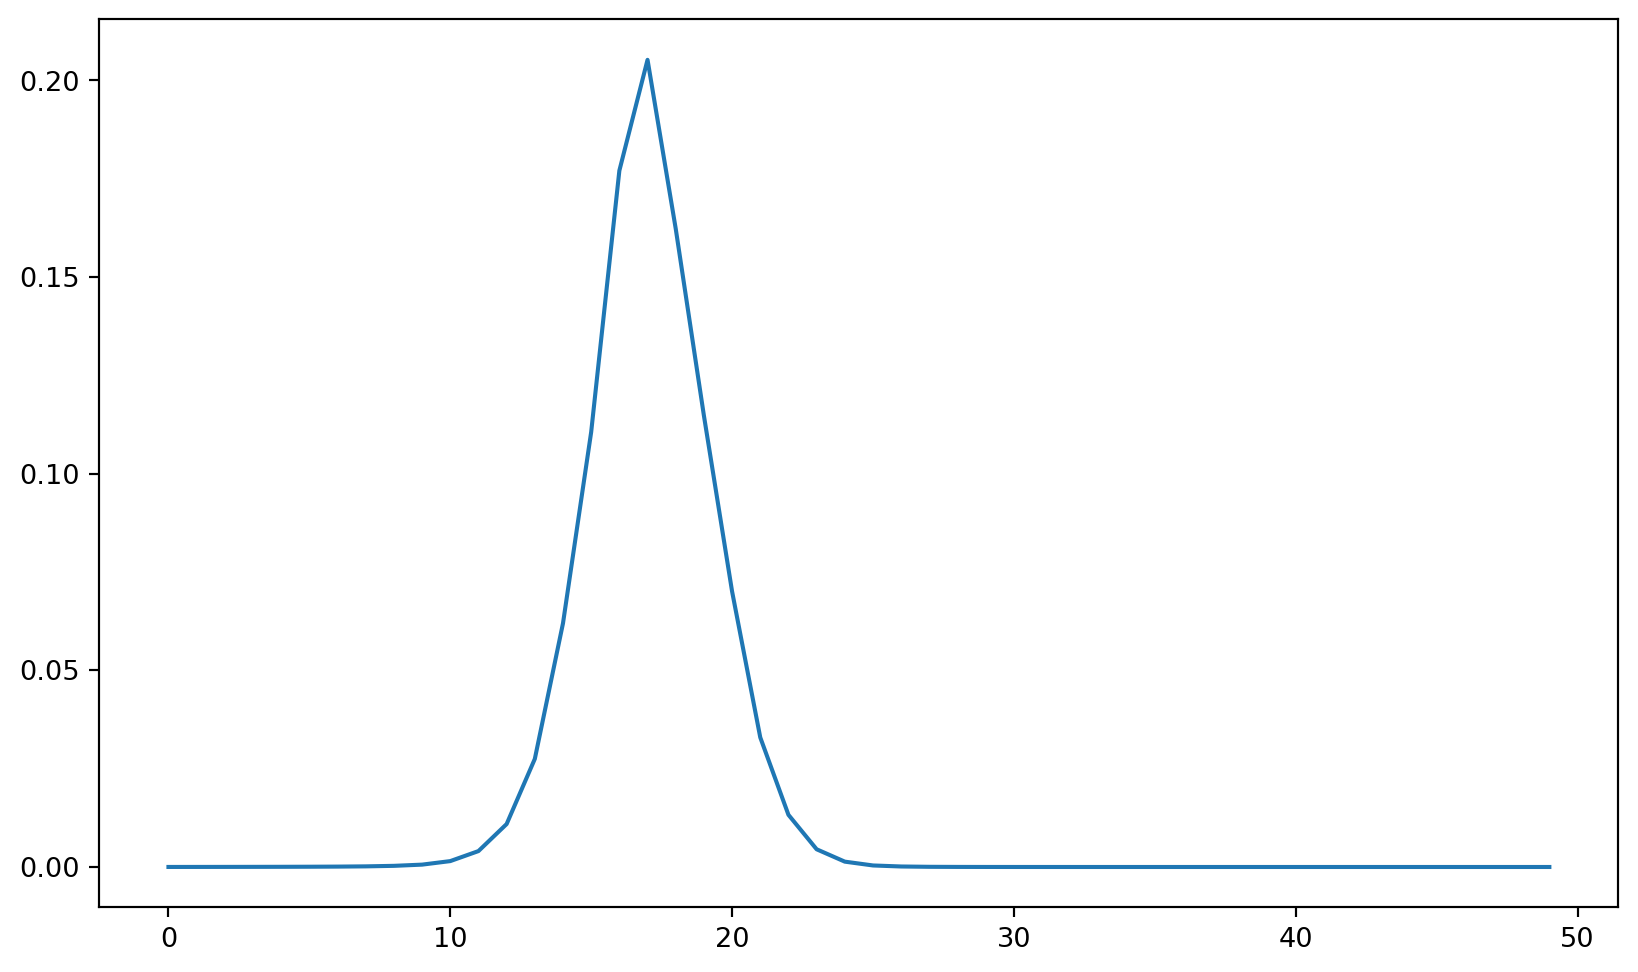

In [68]:
plt.plot(res9.loc[('chn', 1981)].T.values)

In [ ]:
# next, covert headcount to population 

In [70]:
pop_file = '../../../ddf--gapminder--systema_globalis/countries-etc-datapoints/ddf--datapoints--population_total--by--geo--time.csv'
pop = pd.read_csv(pop_file).set_index(['geo', 'time'])['population_total']

In [71]:
pop

geo  time
afg  1800     3280000
     1801     3280000
     1802     3280000
     1803     3280000
     1804     3280000
               ...   
zwe  2096    30940779
     2097    30952208
     2098    30959811
     2099    30964052
     2100    30965421
Name: population_total, Length: 59297, dtype: int64

In [72]:
res10 = []
# gs = res9.groupby(['country', 'year'])
for g, row in res9.iterrows():
    p = pop.loc[g]
    row_pop = np.round(row * p)
    row_pop_str = ', '.join(row_pop.astype(int).astype(str))
    res10.append(row_pop_str)

In [73]:
res10[0]

'38, 62, 101, 171, 297, 549, 1054, 2121, 4469, 9785, 22244, 50807, 114153, 238678, 420643, 590768, 632066, 497472, 310623, 174939, 94564, 51133, 27933, 15301, 8414, 4710, 2669, 1549, 936, 582, 376, 249, 169, 116, 79, 53, 35, 22, 14, 8, 5, 3, 1, 1, 0, 0, 0, 0, 0, 0'

In [74]:
res10[1000]

'0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 3, 5, 9, 15, 26, 43, 74, 146, 323, 725, 1574, 3218, 6019, 9947, 12943, 13296, 11089, 7646, 4567, 2511, 1355, 703, 351, 168, 80, 39, 20, 10, 5, 3, 2'

In [75]:
res11 = pd.Series(res10, res9.index)

In [76]:
res11

country  year
afg      1800    38, 62, 101, 171, 297, 549, 1054, 2121, 4469, ...
         1801    38, 62, 101, 171, 297, 549, 1054, 2121, 4469, ...
         1802    38, 62, 101, 171, 297, 549, 1054, 2121, 4469, ...
         1803    38, 62, 101, 171, 297, 549, 1054, 2121, 4469, ...
         1804    38, 62, 101, 171, 297, 549, 1054, 2121, 4469, ...
                                       ...                        
zwe      2046    0, 0, 13, 123, 229, 384, 602, 928, 1464, 2437,...
         2047    0, 0, 7, 95, 209, 357, 566, 872, 1369, 2224, 3...
         2048    0, 0, 8, 101, 221, 376, 592, 910, 1426, 2311, ...
         2049    0, 0, 8, 105, 232, 394, 618, 949, 1488, 2411, ...
         2050    0, 4, 17, 125, 265, 445, 692, 1060, 1653, 2657...
Length: 48945, dtype: object

In [77]:
res11.name = 'income_mountain_50bracket_shape_for_log'

In [78]:
res11.to_csv('../../ddf--datapoints--income_mountain_50bracket_shape_for_log--by--country--year.csv')